In [87]:
import torch
from torchvision.datasets import CelebA
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load the CelebA dataset
dataset = CelebA(root='./data', transform=transform, download=True)

# Attributes of interest
gender_idx = 20  # 'Male' attribute index: 1 for Male, 0 for Female
hair_attributes = {'Black_Hair': 8, 'Blond_Hair': 9, 'Brown_Hair': 11}  # Indexes for hair colors

# Analyze dataset to determine the need for oversampling
def analyze_imbalance(dataset, subset=None):
    if subset is not None:
        indices = subset.indices
    else:
        indices = range(len(dataset))

    counts = pd.DataFrame(0, columns=hair_attributes.keys(), index=['Male', 'Female'])

    for hair_color, idx in hair_attributes.items():
        male_count = 0
        female_count = 0
        for i in indices:
            if dataset.attr[i, gender_idx] == 1 and dataset.attr[i, idx] == 1:
                male_count += 1
            elif dataset.attr[i, gender_idx] == 0 and dataset.attr[i, idx] == 1:
                female_count += 1

        counts.at['Male', hair_color] = male_count
        counts.at['Female', hair_color] = female_count

    return counts

# Initial imbalance analysis
imbalance_info = analyze_imbalance(dataset)
print(imbalance_info)


Files already downloaded and verified
        Black_Hair  Blond_Hair  Brown_Hair
Male         20122        1387       10389
Female       18784       22880       22803


        Black_Hair  Blond_Hair  Brown_Hair
Male         23800       23140       25398
Female       23405       23744       24369


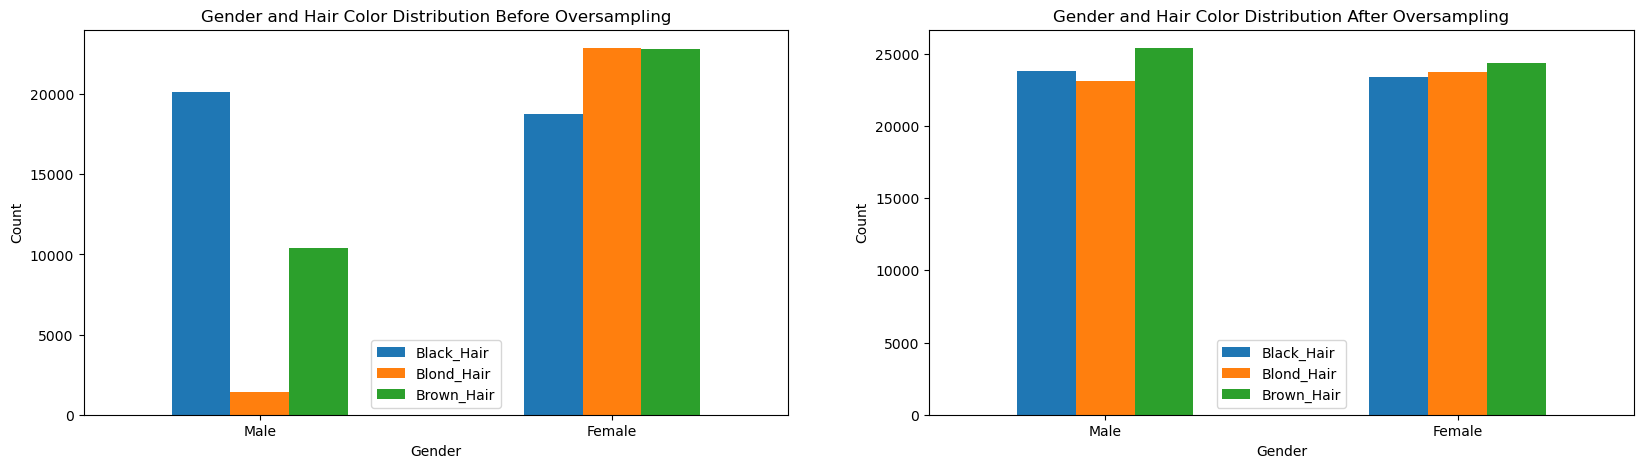

torch.Size([64, 3, 64, 64])


In [49]:
# Function to oversample dataset to balance gender and hair color
def oversample_dataset(dataset, counts, hair_attributes, gender_idx):
    max_count = counts.max().max()  # Find the maximum count to match

    oversampled_indices = []
    for hair, idx in hair_attributes.items():
        for gender, count in counts[hair].items():
            gender_val = 1 if gender == 'Male' else 0
            indices = [i for i, attrs in enumerate(dataset.attr) if attrs[gender_idx] == gender_val and attrs[idx] == 1]

            if not indices:
                print(f"No examples for {gender} with {hair}, skipping oversampling for this group.")
            else:
                if count < max_count:
                    oversampled_indices.extend(np.random.choice(indices, max_count - count, replace=True))
                oversampled_indices.extend(indices)

    np.random.shuffle(oversampled_indices)  # Shuffle to mix
    return Subset(dataset, oversampled_indices)

# Create a balanced dataset through oversampling
balanced_dataset = oversample_dataset(dataset, imbalance_info, hair_attributes, gender_idx)

# Analyze new balance
new_balance_info = analyze_imbalance(dataset, balanced_dataset)
print(new_balance_info)

# Plotting the imbalance and new balance
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
imbalance_info.plot(kind='bar', ax=ax[0])
ax[0].set_title('Gender and Hair Color Distribution Before Oversampling')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Gender')
ax[0].tick_params(axis='x', rotation=0)

new_balance_info.plot(kind='bar', ax=ax[1])
ax[1].set_title('Gender and Hair Color Distribution After Oversampling')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Gender')
ax[1].tick_params(axis='x', rotation=0)

plt.show()

# Data loader for the balanced dataset
loader = DataLoader(balanced_dataset, batch_size=64, shuffle=True)

# Example of using the data loader
for images, labels in loader:
    print(images.shape)  # Output the shape of images batch
    break  # Only process the first batch for demonstration

        Black_Hair  Blond_Hair  Brown_Hair
Male          1443        1404        1536
Female        1421        1434        1484


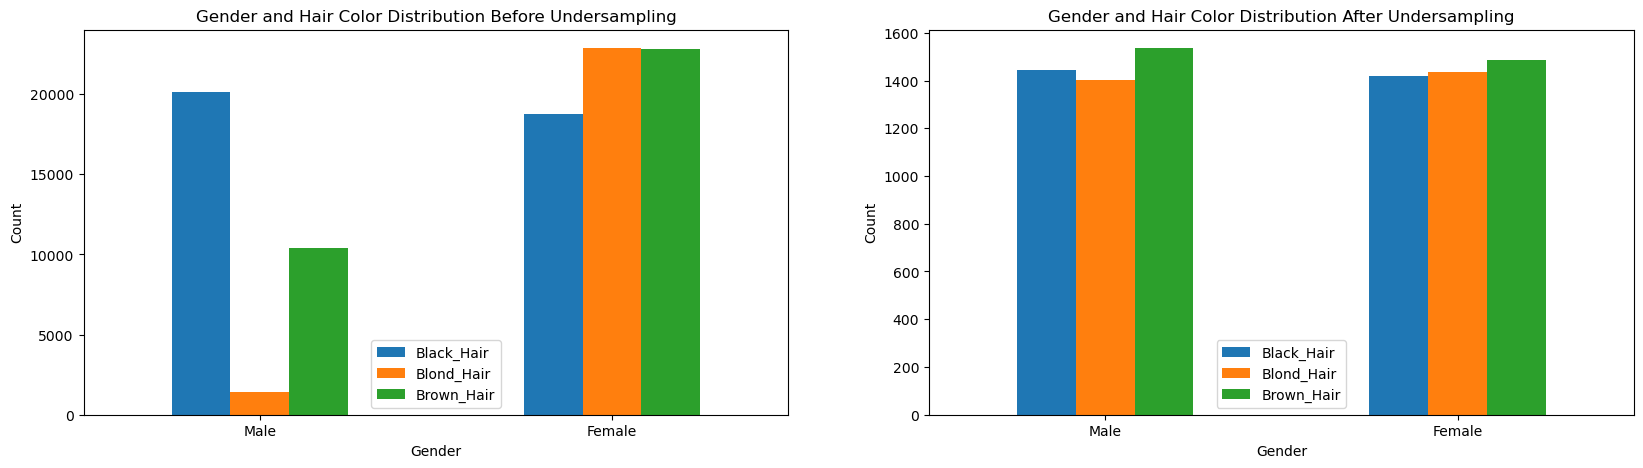

torch.Size([64, 3, 64, 64])


In [89]:
# Function to undersample dataset to balance gender and hair color
def undersample_dataset(dataset, counts, hair_attributes, gender_idx):
    min_count = counts.min().min()  # Find the minimum count to match

    undersampled_indices = []
    for hair, idx in hair_attributes.items():
        for gender, count in counts[hair].items():
            gender_val = 1 if gender == 'Male' else 0
            # Collect all indices for the current gender and hair color
            indices = [i for i, attrs in enumerate(dataset.attr) if attrs[gender_idx] == gender_val and attrs[idx] == 1]

            # If the current count is greater than the minimum count, randomly select `min_count` indices
            if count > min_count:
                undersampled_indices.extend(np.random.choice(indices, min_count, replace=False))
            else:
                undersampled_indices.extend(indices)

    np.random.shuffle(undersampled_indices)  # Shuffle to mix
    return Subset(dataset, undersampled_indices)

# Create a balanced dataset through undersampling
balanced_dataset = undersample_dataset(dataset, imbalance_info, hair_attributes, gender_idx)

# Analyze new balance
new_balance_info = analyze_imbalance(dataset, balanced_dataset)
print(new_balance_info)

# Plotting the imbalance and new balance
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
imbalance_info.plot(kind='bar', ax=ax[0])
ax[0].set_title('Gender and Hair Color Distribution Before Undersampling')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Gender')
ax[0].tick_params(axis='x', rotation=0)

new_balance_info.plot(kind='bar', ax=ax[1])
ax[1].set_title('Gender and Hair Color Distribution After Undersampling')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Gender')
ax[1].tick_params(axis='x', rotation=0)

plt.show()

# Data loader for the balanced dataset
loader = DataLoader(balanced_dataset, batch_size=64, shuffle=True)

# Example of using the data loader
for images, labels in loader:
    print(images.shape)  # Output the shape of images batch
    break  # Only process the first batch for demonstration

Original Balance:
        Black_Hair  Blond_Hair  Brown_Hair
Male         20122        1387       10389
Female       18784       22880       22803
Biased Balance:
        Black_Hair  Blond_Hair  Brown_Hair
Male         20122        1387       10389
Female       18784       11546       22369


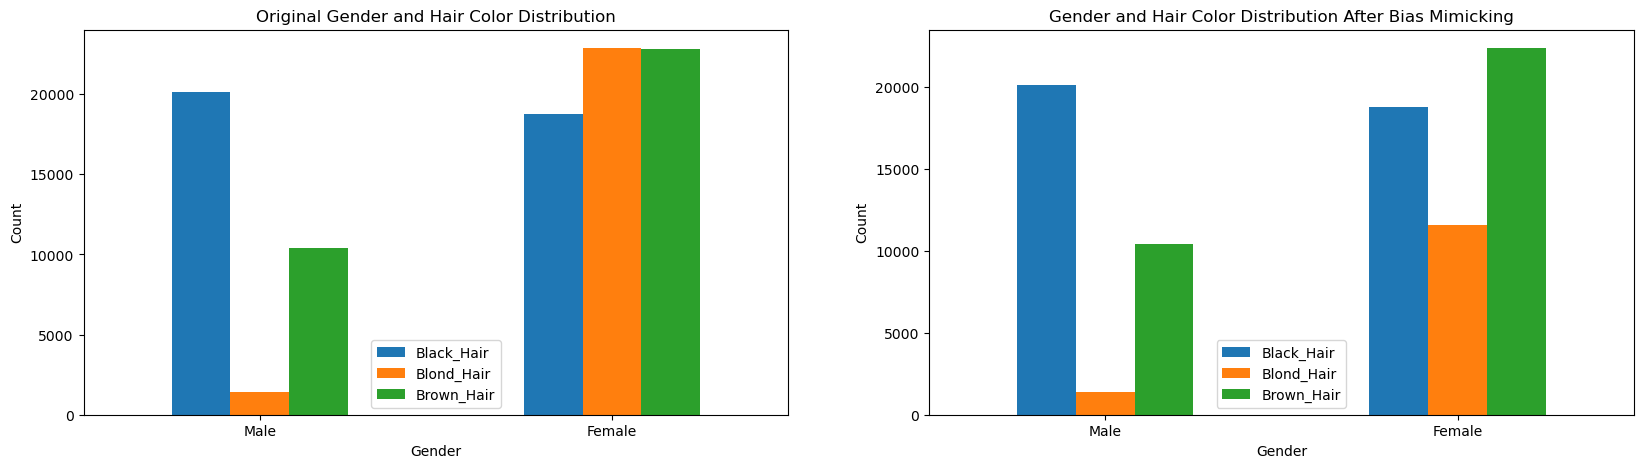

torch.Size([64, 3, 64, 64])


In [90]:
# Function to mimic bias in the dataset by reducing the representation of specified attributes
def mimic_bias(dataset, target_gender, target_hair_color, reduction_factor=0.5):
    # Attributes of interest
    gender_idx = 20  # 'Male' attribute index: 1 for Male, 0 for Female
    hair_attributes = {'Black_Hair': 8, 'Blond_Hair': 9, 'Brown_Hair': 11}  # Indexes for hair colors

    biased_indices = []
    for i, attrs in enumerate(dataset.attr):
        # Check if the current entry matches the target gender and hair color
        if attrs[gender_idx] == (1 if target_gender == 'Male' else 0) and attrs[hair_attributes[target_hair_color]] == 1:
            # Randomly decide whether to keep this entry based on the reduction factor
            if np.random.rand() > reduction_factor:
                biased_indices.append(i)
        else:
            # Add all non-targeted entries
            biased_indices.append(i)

    np.random.shuffle(biased_indices)  # Shuffle to mix
    return Subset(dataset, biased_indices)

# Bias mimicking: Reduce the representation of females with blond hair by 50%
biased_dataset = mimic_bias(dataset, 'Female', 'Blond_Hair', reduction_factor=0.5)

# Analyze imbalance before and after bias introduction
original_balance_info = analyze_imbalance(dataset)
biased_balance_info = analyze_imbalance(dataset, biased_dataset)

# Output imbalance information
print("Original Balance:")
print(original_balance_info)
print("Biased Balance:")
print(biased_balance_info)

# Plotting the imbalance before and after bias mimicking
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
original_balance_info.plot(kind='bar', ax=ax[0])
ax[0].set_title('Original Gender and Hair Color Distribution')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Gender')
ax[0].tick_params(axis='x', rotation=0)

biased_balance_info.plot(kind='bar', ax=ax[1])
ax[1].set_title('Gender and Hair Color Distribution After Bias Mimicking')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Gender')
ax[1].tick_params(axis='x', rotation=0)

plt.show()

# Data loader for the biased dataset
loader = DataLoader(biased_dataset, batch_size=64, shuffle=True)

# Example of using the data loader
for images, labels in loader:
    print(images.shape)  # Output the shape of images batch 
    break # Only process the first batch for demonstration


Mean Squared Error (MSE) between original and biased balances: 21557308.5
Chi-squared Test:
Chi-squared Statistic: 2720.9510000801783
P-value: 0.0
Degrees of Freedom: 2

Expected Frequencies:
            Black_Hair    Blond_Hair    Brown_Hair
Original  41440.800574  19795.570247  35128.629179
Biased    36370.199426  17373.429753  30830.370821


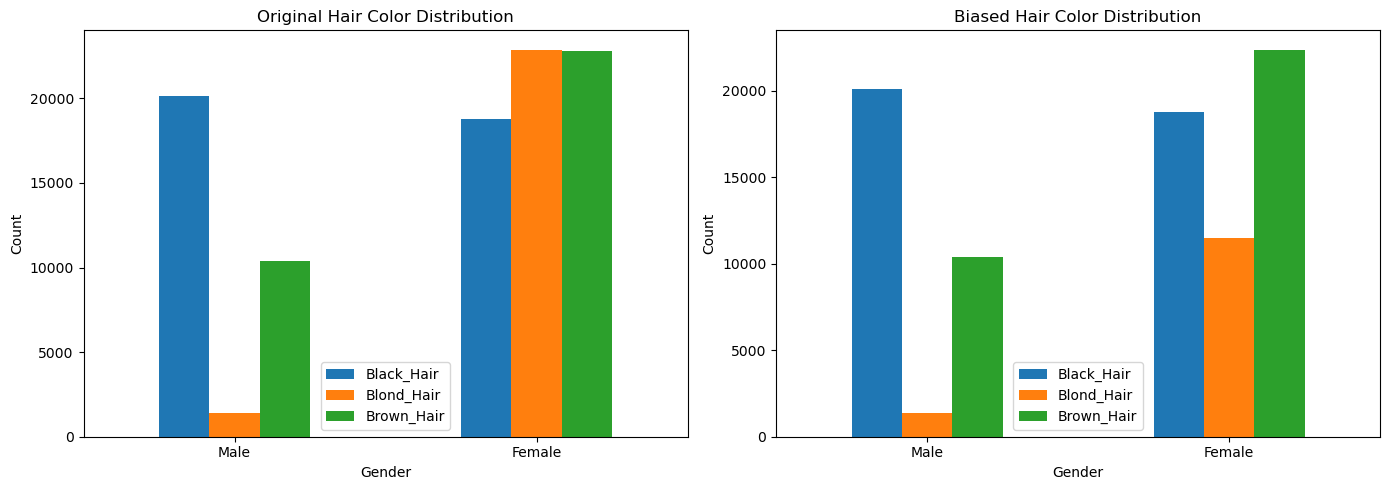

Reject the null hypothesis - Significant difference due to bias mimicking.


In [92]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Manually create the DataFrame to match the given outcome structure
original_balance = pd.DataFrame({
    'Black_Hair': [20122, 18784],
    'Blond_Hair': [1387, 22880],
    'Brown_Hair': [10389, 22803]
}, index=['Male', 'Female'])

biased_balance = pd.DataFrame({
    'Black_Hair': [20122, 18783],
    'Blond_Hair': [1387, 11515],
    'Brown_Hair': [10389, 22378]
}, index=['Male', 'Female'])

# Calculate MSE
mse = ((original_balance - biased_balance) ** 2).mean().mean()
print("Mean Squared Error (MSE) between original and biased balances:", mse)

# Concatenate data for Chi-squared test
data = pd.concat([original_balance.sum(axis=0), biased_balance.sum(axis=0)], axis=1).T

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(data)

# Output results
print("Chi-squared Test:")
print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}\n")
print("Expected Frequencies:")
print(pd.DataFrame(expected, columns=data.columns, index=['Original', 'Biased']))

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

original_balance.plot(kind='bar', ax=axes[0], title='Original Hair Color Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Gender')
axes[0].tick_params(axis='x', rotation=0)

biased_balance.plot(kind='bar', ax=axes[1], title='Biased Hair Color Distribution')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Gender')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Interpretation
if p < 0.05:
    print("Reject the null hypothesis - Significant difference due to bias mimicking.")
else:
    print("Fail to reject the null hypothesis - No significant difference.")
